# Graph Neural Networks

In this tutorial, we will explore the implementation of graph neural networks and investigate what representations these networks learn. Along the way, we'll see how PyTorch Geometric and TensorBoardX can help us with constructing and training graph models.

We'll first demonstrate some essential features of PyTorch which we'll use throughout. PyTorch is a general machine learning library that allows us to dynamically define computation graphs which we'll use to describe our models and their training processes.

We'll start by importing everything we need:

# Setup

Let's first install PyTorch Geometric (which we'll use for creating graph neural networks) and TensorboardX (which we'll use to visualize training progress):

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.transforms as T


from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Defining the model

The `GNNStack` is our general framework for a GNN which can handle different types of convolutional layers, and both node and graph classification. The `build_conv_model` method determines which type of convolutional layer to use for the given task -- here we choose to use a graph convolutional network for node classification, and a graph isomorphism network for graph classification. Note that PyTorch Geometric provides out-of-the-box modules for these layers, which we use here. The model consists of 3 layers of convolution, followed by mean pooling in the case of graph classification, followed by two fully-connected layers. Since our goal here is classification, we use a negative log-likelihood loss function.

In [21]:
class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, task='node'):
        super(GNNStack, self).__init__()
        self.task = task
        self.convs = nn.ModuleList()
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        self.lns = nn.ModuleList()
        self.lns.append(nn.LayerNorm(hidden_dim))
        self.lns.append(nn.LayerNorm(hidden_dim))
        for l in range(2):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25), 
            nn.Linear(hidden_dim, output_dim))
        if not (self.task == 'node' or self.task == 'graph'):
            raise RuntimeError('Unknown task.')

        self.dropout = 0.25
        self.num_layers = 3

    def build_conv_model(self, input_dim, hidden_dim):
        # refer to pytorch geometric nn module for different implementation of GNNs.
        if self.task == 'node':
            return pyg_nn.GCNConv(input_dim, hidden_dim)
        else:
            return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                  nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if data.num_node_features == 0:
          x = torch.ones(data.num_nodes, 1)

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if not i == self.num_layers - 1:
                x = self.lns[i](x)

        if self.task == 'graph':
            x = pyg_nn.global_mean_pool(x, batch)

        x = self.post_mp(x)

        return emb, F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

Here pyg_nn.GCNConv and pyg_nn.GINConv are instances of MessagePassing. They define a single layer of graph convolution, which can be decomposed into:
* Message computation
* Aggregation
* Update
* Pooling

Here we give an example of how to subclass the pytorch geometric MessagePassing class to derive a new model (rather than using existing GCNConv and GINConv).

We make use of `MessagePassing`'s key building blocks:
- `aggr='add'`: The aggregation method to use ("add", "mean" or "max").
- `propagate()`: The initial call to start propagating messages. Takes in the edge indices and any other data to pass along (e.g. to update node embeddings).
- `message()`: Constructs messages to node i. Takes any argument which was initially passed to propagate().
- `update()`: Updates node embeddings. Takes in the output of aggregation as first argument and any argument which was initially passed to propagate().


In [22]:
class CustomConv(pyg_nn.MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(CustomConv, self).__init__(aggr='add')  # "Add" aggregation.
        self.lin = nn.Linear(in_channels, out_channels)
        self.lin_self = nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Add self-loops to the adjacency matrix.
        edge_index, _ = pyg_utils.remove_self_loops(edge_index)

        # Transform node feature matrix.
        self_x = self.lin_self(x)
        #x = self.lin(x)

        return self_x + self.propagate(edge_index, size=(x.size(0), x.size(0)), x=self.lin(x))

    def message(self, x_i, x_j, edge_index, size):
        # Compute messages
        # x_j has shape [E, out_channels]

        row, col = edge_index
        deg = pyg_utils.degree(row, size[0], dtype=x_j.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        return x_j

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]
        return aggr_out

# Training setup

We train the model in a standard way here, running it forwards to compute its predicted label distribution and backpropagating the error. Note the task setup in our graph setting: for node classification, we define a subset of nodes to be training nodes and the rest of the nodes to be test nodes, and mask out the test nodes during training via `batch.train_mask`. For graph classification, we use 80% of the graphs for training and the remainder for testing, as in other classification settings.

In [23]:
def train(dataset, task):
    if task == 'graph':
        data_size = len(dataset)
        loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=64, shuffle=True)
        test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=64, shuffle=True)
    else:
        test_loader = loader = DataLoader(dataset, batch_size=64, shuffle=True)

    # build model
    model = GNNStack(max(dataset.num_node_features, 1), 32, dataset.num_classes, task=task)
    opt = optim.Adam(model.parameters(), lr=0.01)
    
    # train
    for epoch in range(200):
        total_loss = 0
        model.train()
        for batch in loader:
            #print(batch.train_mask, '----')
            opt.zero_grad()
            embedding, pred = model(batch)
            label = batch.y
            if task == 'node':
                pred = pred[batch.train_mask]
                label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)

        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            print("Epoch {}. Loss: {:.4f}. Test accuracy: {:.4f}".format(
                epoch, total_loss, test_acc))

    return model


Test time, for the CiteSeer/Cora node classification task, there is only 1 graph. So we use masking to determine validation and test set.

For graph classification tasks, a subset of graphs is considered validation / test graph.

In [24]:
def test(loader, model, is_validation=False):
    model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad():
            emb, pred = model(data)
            pred = pred.argmax(dim=1)
            label = data.y

        if model.task == 'node':
            mask = data.val_mask if is_validation else data.test_mask
            # node classification: only evaluate on nodes in test set
            pred = pred[mask]
            label = data.y[mask]
            
        correct += pred.eq(label).sum().item()
    
    if model.task == 'graph':
        total = len(loader.dataset) 
    else:
        total = 0
        for data in loader.dataset:
            total += torch.sum(data.test_mask).item()
    return correct / total

# Training the model

Let's train our model and visualize its progress. First, run this snippet to generate a link to TensorBoardX, which will take you to a page where you can visualize the loss and accuracy curves of the model.

In [25]:
from torch_geometric.datasets import TUDataset

# dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
dataset = TUDataset(root='/tmp/IMDB-BINARY', name='IMDB-BINARY')
dataset = dataset.shuffle()
task = 'graph'

model = train(dataset, task)

/Users/tristanbilot/opt/anaconda3/envs/pyg/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 0. Loss: 0.7081. Test accuracy: 0.5350
Epoch 10. Loss: 0.6924. Test accuracy: 0.6750
Epoch 20. Loss: 0.6961. Test accuracy: 0.5350
Epoch 30. Loss: 0.6927. Test accuracy: 0.4400
Epoch 40. Loss: 0.6949. Test accuracy: 0.4650
Epoch 50. Loss: 0.6933. Test accuracy: 0.4650
Epoch 60. Loss: 0.6932. Test accuracy: 0.4650
Epoch 70. Loss: 0.6935. Test accuracy: 0.4650
Epoch 80. Loss: 0.6938. Test accuracy: 0.4650
Epoch 90. Loss: 0.6933. Test accuracy: 0.4650
Epoch 100. Loss: 0.6929. Test accuracy: 0.4650
Epoch 110. Loss: 0.6930. Test accuracy: 0.4650
Epoch 120. Loss: 0.6931. Test accuracy: 0.4650
Epoch 130. Loss: 0.6930. Test accuracy: 0.4650
Epoch 140. Loss: 0.6934. Test accuracy: 0.4650
Epoch 150. Loss: 0.6934. Test accuracy: 0.4650
Epoch 160. Loss: 0.6933. Test accuracy: 0.4650
Epoch 170. Loss: 0.6936. Test accuracy: 0.5350
Epoch 180. Loss: 0.6931. Test accuracy: 0.4650
Epoch 190. Loss: 0.6934. Test accuracy: 0.4650


Here we try a node classification task on the Citeseer citation network:

In [15]:
dataset = Planetoid(root='/tmp/cora', name='cora')
task = 'node'

model = train(dataset, task)

Processing...
Done!
/Users/tristanbilot/opt/anaconda3/envs/pyg/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 0. Loss: 2.0103. Test accuracy: 0.2500
Epoch 10. Loss: 0.4651. Test accuracy: 0.7650
Epoch 20. Loss: 0.0411. Test accuracy: 0.7500
Epoch 30. Loss: 0.0935. Test accuracy: 0.7470
Epoch 40. Loss: 0.0218. Test accuracy: 0.7170
Epoch 50. Loss: 0.0164. Test accuracy: 0.7350
Epoch 60. Loss: 0.0048. Test accuracy: 0.7170
Epoch 70. Loss: 0.0507. Test accuracy: 0.7490
Epoch 80. Loss: 0.0135. Test accuracy: 0.7410
Epoch 90. Loss: 0.0034. Test accuracy: 0.7380
Epoch 100. Loss: 0.0318. Test accuracy: 0.7380
Epoch 110. Loss: 0.0324. Test accuracy: 0.7420
Epoch 120. Loss: 0.0030. Test accuracy: 0.7500
Epoch 130. Loss: 0.0007. Test accuracy: 0.7490
Epoch 140. Loss: 0.0065. Test accuracy: 0.7470
Epoch 150. Loss: 0.0004. Test accuracy: 0.7720
Epoch 160. Loss: 0.0013. Test accuracy: 0.7370
Epoch 170. Loss: 0.0031. Test accuracy: 0.7240
Epoch 180. Loss: 0.0038. Test accuracy: 0.7410
Epoch 190. Loss: 0.0004. Test accuracy: 0.7350


# Visualizing node embeddings

One great quality about graph neural networks is that, like other deep methods, their hidden layers provide low-dimensional representations of our data. In the case of node classification, we get a low-dimensional representation for each node in our graph. Let's visualize the output of the last convolutional layer in our node classification GNN via TSNE, a method for plotting high-dimensional data. Nodes are colored according to their labels. We see that nodes with similar labels tend to be near each other in the embedding space, a good indication that our model has learned a useful representation.

64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
40


/Users/tristanbilot/opt/anaconda3/envs/pyg/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/tristanbilot/opt/anaconda3/envs/pyg/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


ValueError: 'c' argument has 1000 elements, which is inconsistent with 'x' and 'y' with size 19773.

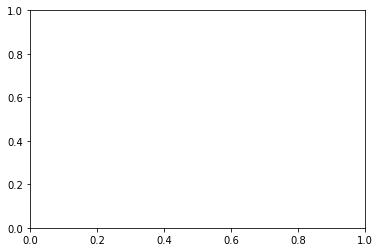

In [19]:
color_list = ["red", "orange", "green", "blue", "purple", "brown"]

loader = DataLoader(dataset, batch_size=64, shuffle=True)
embs = []
colors = []
for batch in loader:
    emb, pred = model(batch)
    embs.append(emb)
    colors += [color_list[y] for y in batch.y]
embs = torch.cat(embs, dim=0)

xs, ys = zip(*TSNE().fit_transform(embs.detach().numpy()))
plt.scatter(xs, ys, color=colors)

# Learning unsupervised embeddings with graph autoencoders

Finally, GNNs fit nicely in the framework of other neural approaches, and can be used as part of autoencoder techniques, pretraining and multitask learning methods, etc. Here we explore the idea of neural network representations further by building a graph autoencoder which learns these representations in a completely unsupervised way. In contrast to the previous example, we do not make use of the given node labels when training this representation. Instead, we encode the nodes in our network in a low-dimensional space in such a way that the embeddings can be decoded into a reconstruction of the original network. We use graph convolutional layers in the encoder.

You can again use TensorBoardX here to visualize the training progress.

In [ ]:
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = pyg_nn.GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = pyg_nn.GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

def train(epoch):
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    loss.backward()
    optimizer.step()
    

def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)


dataset = Planetoid("/tmp/citeseer", "Citeseer", T.NormalizeFeatures())
data = dataset[0]

channels = 16
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('CUDA availability:', torch.cuda.is_available())

# encoder: written by us; decoder: default (inner product)
model = pyg_nn.GAE(Encoder(dataset.num_features, channels)).to(dev)
labels = data.y
data.train_mask = data.val_mask = data.test_mask = data.y = None
data = model.split_edges(data)
x, train_pos_edge_index = data.x.to(dev), data.train_pos_edge_index.to(dev)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1, 201):
    train(epoch)
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    if epoch % 10 == 0:
        print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

Processing...
Done!
CUDA availability: True
Epoch: 010, AUC: 0.6453, AP: 0.7231
Epoch: 020, AUC: 0.7695, AP: 0.7843
Epoch: 030, AUC: 0.7950, AP: 0.8051
Epoch: 040, AUC: 0.8226, AP: 0.8290
Epoch: 050, AUC: 0.8220, AP: 0.8285
Epoch: 060, AUC: 0.8175, AP: 0.8242
Epoch: 070, AUC: 0.8254, AP: 0.8336
Epoch: 080, AUC: 0.8362, AP: 0.8386
Epoch: 090, AUC: 0.8387, AP: 0.8390
Epoch: 100, AUC: 0.8363, AP: 0.8415
Epoch: 110, AUC: 0.8357, AP: 0.8416
Epoch: 120, AUC: 0.8378, AP: 0.8456
Epoch: 130, AUC: 0.8410, AP: 0.8484
Epoch: 140, AUC: 0.8489, AP: 0.8588
Epoch: 150, AUC: 0.8503, AP: 0.8602
Epoch: 160, AUC: 0.8470, AP: 0.8566
Epoch: 170, AUC: 0.8456, AP: 0.8563
Epoch: 180, AUC: 0.8437, AP: 0.8532
Epoch: 190, AUC: 0.8426, AP: 0.8536
Epoch: 200, AUC: 0.8412, AP: 0.8511


Finally, we plot our embeddings (the output of the encoder) with TSNE. We color each node embedding according to its label -- but note that we did not use any label information when training our encoder. Nodes with the same label are nevetheless close together in the embedding space. The model has learned the community structure without supervision!

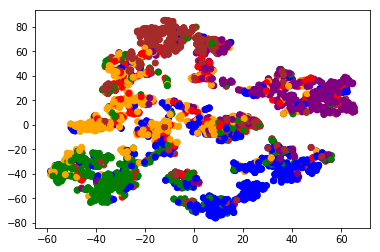

In [ ]:
model.eval()
z = model.encode(x, train_pos_edge_index)
colors = [color_list[y] for y in labels]

xs, ys = zip(*TSNE().fit_transform(z.cpu().detach().numpy()))
plt.scatter(xs, ys, color=colors)
plt.show()